In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from importlib import reload
from mppi import Parsers as P

# Tutorial of the PwParser

In [156]:
results = P.PwParser('si_scf_ecut10_k3',path='PwParser_folder')
#results = P.PwParser('si_nscf_k6_nb100',path='PwParser_folder')

Parse file : PwParser_folder/si_scf_ecut10_k3.save/data-file-schema.xml


In [157]:
results.atomic_positions

[['Si', [-1.2875, 1.2875, 1.2875]], ['Si', [1.2875, -1.2875, -1.2875]]]

In [158]:
results.atomic_species

{'Si': ['2.808600000000000e1', 'Si.pbe-mt_fhi.UPF']}

In [159]:
results.nkpoints

6

In [160]:
results.nbands

4

In [161]:
results.kpoints

[[0.0, 0.0, 0.0],
 [-0.3333333333333333, 0.3333333333333333, -0.3333333333333333],
 [0.0, 0.6666666666666666, 0.0],
 [0.6666666666666669, -5.551115123125783e-17, 0.6666666666666669],
 [-0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 [-0.6666666666666669, 0.6666666666666669, 0.0]]

In [162]:
results.evals

array([[-0.20362013,  0.23008746,  0.23009597,  0.23009597],
       [-0.15364325,  0.03525018,  0.19221198,  0.19221959],
       [-0.13371509,  0.0489887 ,  0.13980064,  0.1398055 ],
       [-0.08408231, -0.01551476,  0.06707819,  0.15095046],
       [-0.15364376,  0.03524954,  0.19221929,  0.19221929],
       [-0.08408382, -0.01551278,  0.0670755 ,  0.15095544]])

In [163]:
results.occupations

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [164]:
results.fermi

0.2300959736436337

In [165]:
results.energy

-7.828160394451467

In [172]:
def eval_kpath(kpoints):
    """
    Assumes that list of kpoitns is given along a path. Compute the curvilinear ascissa
    along the path.
    
    Args:
        kpoint(list) : list of kpoints ordered along a path
        
    Returns:
        kpath(list) : list the value of the curvilinear ascissa along the path
    """
    kpoints = np.array(kpoints)
    kpath = [0]
    distance = 0
    for nk in range(1,len(kpoints)):
        distance += np.linalg.norm(kpoints[nk-1]-kpoints[nk])
        kpath.append(distance)   
    return kpath

def eval_bands(evals):
    """
    Convert the evals array of :py:class:`PwParser` in a the array bands,
    where bands[i] gives the energies of the i-th band along the path
    """
    import numpy as np
    bands = []
    for b in range(len(results.evals[0])): #number of bands
        bands.append(evals[:,b])
    return np.array(bands)


In [212]:
results = P.PwParser('gaas_bands',path='PwParser_folder')

Parse file : PwParser_folder/gaas_bands.save/data-file-schema.xml


In [213]:
kpath = eval_kpath(results.kpoints)
bands = eval_bands(results.evals)

In [214]:
import matplotlib.pyplot as plt

(-4, 4)

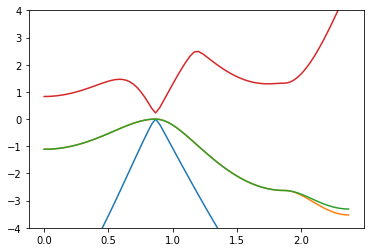

In [221]:
HaToEv = 27.211386

fermi = results.fermi*HaToEv

for b in bands[1:5]:
    plt.plot(kpath,HatoeV*b-fermi)
plt.ylim(-4,4)

In [9]:
########################################################################################

In [166]:
import xml.etree.ElementTree as ET
import os
import numpy as np

#from qepy.auxiliary import *
#from .lattice import *

#from yambopy.plot.plotting import add_fig_kwargs 

__all__ = ['PwXML']

HatoeV = 27.2107

def calculate_distances(kpoints):
    """
    take a list of k-points and calculate the distances between all of them
    """
    kpoints = np.array(kpoints)
    distances = [0]
    distance = 0
    for nk in range(1,len(kpoints)):
        distance += np.linalg.norm(kpoints[nk-1]-kpoints[nk])
        distances.append(distance)   
    return distances

class Path(object):
    """ Class that defines a path in the brillouin zone
    """
    def __init__(self,klist,intervals):
        """
        Generation of a path in reciprocal space by specifying a list of k-points
        """
        self.intervals = intervals

        klabels = []
        kpoints = []
        for kpoint, klabel in klist:
            kpoints.append(kpoint)
            klabels.append(klabel)
        self.kpoints = np.array(kpoints)
        self.klabels = klabels
    
    def as_dict(self):
        d = {'kpoints':self.kpoints.tolist(),
             'klabels':self.klabels,
             'intervals':self.intervals}
        return d

    @classmethod
    def from_dict(cls,d):
        klist = zip(d['kpoints'],d['klabels'])
        return cls(klist,d['intervals'])

    @property
    def distances(self):
        if hasattr(self,'_distances'): return self._distances
        k0 = np.array(self.kpoints[0])
        dist = 0
        distances = [0]
        for kpt in np.array(self.kpoints[1:]):
            dist += np.linalg.norm(kpt-k0)
            k0 = kpt
            distances.append(dist)
        self._distances = distances
        return distances

    def set_xticks(self,ax):
        ax.set_xticks(self.distances)
        ax.set_xticklabels(self.klabels)

    def __iter__(self):
        return iter(zip(self.kpoints,self.klabels,self.distances))

    def get_klist(self):
        """ 
        Output in the format of quantum espresso == [ [kx, ky, kz, 1], ... ]
        """
        kpoints = self.kpoints
        intervals = self.intervals
        kout  = np.zeros([sum(intervals)+1,4])
        kout[:,3] = 1
        io = 0
        for ik,interval in enumerate(intervals):
          for ip in range(interval):
            kout[io,:3] = kpoints[ik] + float(ip)/interval*(kpoints[ik+1] - kpoints[ik])
            io = io + 1
        kout[io,:3] = kpoints[ik] + float(ip+1)/interval*(kpoints[ik+1] - kpoints[ik])

        return kout

    def get_indexes(self):
        """ get the index of each point of the path
        """

        indexes = []
        index = 0
        for n,label in enumerate(self.intervals):
            indexes.append([index,self.klabels[n]])
            index += self.intervals[n] 
        indexes.append([index,self.klabels[-1]])
        return indexes

def vec_in_list(veca,vec_list,atol=1e-6):
    """ check if a vector exists in a list of vectors
    """
    return np.array([ np.allclose(veca,vecb,rtol=atol,atol=atol) for vecb in vec_list ]).any()

def red_car(red,lat):
    """
    Convert reduced coordinates to cartesian
    """
    lat = np.array(lat)
    red = np.array(red)
    if lat.shape != (3,3):
        raise ValueError('Wrong lattice dimensions expected (3,3) got {}'.format(lat.shape))
    return np.array([coord[0]*lat[0]+coord[1]*lat[1]+coord[2]*lat[2] for coord in red])

def car_red(car,lat):
    """
    Convert cartesian coordinates to reduced
    """
    car = np.array(car)
    lat = np.array(lat)
    if lat.shape != (3,3):
        raise ValueError('Wrong lattice dimensions expected (3,3) got {}'.format(lat.shape))
    return np.array([np.linalg.solve(np.array(lat).T,coord) for coord in car])

def rec_lat(lat):
    """
    Calculate the reciprocal lattice vectors
    """
    a1,a2,a3 = np.array(lat)
    v = np.dot(a1,np.cross(a2,a3))
    b1 = np.cross(a2,a3)/v
    b2 = np.cross(a3,a1)/v
    b3 = np.cross(a1,a2)/v
    return np.array([b1,b2,b3])

